In [128]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import LeNet, aliG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.4.1


In [30]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

## Loading the data (MNIST)

In [32]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [33]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 1000


## 1) LeNet with disjoint trainset and testset

In [34]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [35]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.02151           0.326         0.00192           0.435
10                      0.00240           0.928         0.00031           0.896
20                      0.00038           0.993         0.00020           0.930
30                      0.00009           1.000         0.00020           0.932
40                      0.00004           1.000         0.00020           0.933
49                      0.00003           1.000         0.00020           0.934
*******************************************************************************


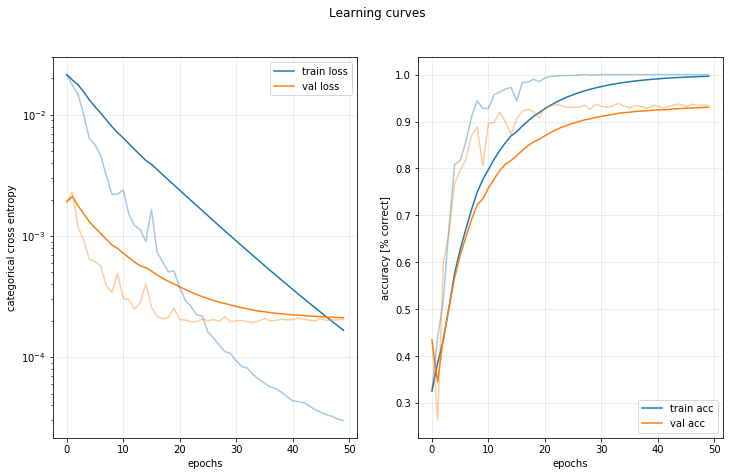

In [37]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [38]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [39]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [40]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -1.3434,   1.9327,  -0.2633,   8.7755, -15.1506,  14.9290,  -4.3565,
          -3.2553,   5.2376,  -2.5099],
        [ 15.0522,  -3.0100,   1.7743,  -1.9196,  -9.2371,   0.2206,   0.5000,
          -0.9488,  -1.7435,   2.9767],
        [ -6.8549,  -2.5195,  -1.9979,   0.8930,  14.5098,  -1.0922,  -4.2013,
           1.6914,  -6.6229,   6.2329],
        [ -3.7498,  15.7786,   3.5180,  -6.1765,   0.7682,  -8.6203,  -1.0121,
           3.1323,   2.5722,  -7.3561],
        [ -9.5931,  -1.7124,  -6.0498,   0.6003,   8.3834,  -1.3628,  -6.1722,
           0.4341,   0.4142,  13.7272],
        [ -1.2126,  -3.8183,  11.2334,   3.8368,  -9.6302,  -2.1933,  -3.2992,
           2.7752,   4.1476,   1.8850],
        [ -8.0436,  10.8101,  -0.5868,  -1.1138,  -0.5599,  -0.7863,  -1.4813,
          -1.7015,   3.0663,  -2.5218],
        [ -5.4495,  -1.1492,   1.9252,  21.2713, -13.7452,   4.7089, -15.0026,
           1.4263,   4.4620,   6.1703],
        [ -6.1222,  10.7618,  -1.6399,  -2.7180,

In [41]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [42]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [43]:
#Size of input vector can be changed
modelG = aliG(142)

In [44]:
debug_layers_dims(modelG, [1, 1, 142])

******************** Debugging layers sizes: ********************
input_shape= (_,1,142)
------------------
Conv1d(1, 32, kernel_size=(8,), stride=(1,))
(_,1,142) --> (_,32,135)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,32,135) --> (_,32,67)
------------------
Conv1d(32, 128, kernel_size=(5,), stride=(1,))
(_,32,67) --> (_,128,63)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,128,63) --> (_,128,31)
------------------
Conv1d(128, 16, kernel_size=(3,), stride=(1,))
(_,128,31) --> (_,16,29)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,16,29) --> (_,16,14)
------------------
View(_, [-1])
(_,16,14) --> (_,224)
------------------
Linear(in_features=224, out_features=100, bias=True)
(_,224) --> (_,100)
------------------
Linear(in_features=100, out_features=32, bias=True)
(_,100) --> (_,32)
------------------
Linear(in_features=32, out_

tensor([[0.0631],
        [0.0464]], grad_fn=<ThAddmmBackward>)

In [129]:
layer = model.fc1
layer_name = "fc1"

In [130]:
(g_train_dataset, g_test_dataset) = generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7)

In [131]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of input vector :", size_input_vector)

size of input vector : 200


In [132]:
g_train_dataset[0][0:110].shape

torch.Size([110, 1, 200])

In [133]:
modelG(g_train_dataset[0][0:10])

tensor([[-0.1400],
        [-0.1115],
        [-0.1226],
        [-0.1213],
        [-0.1261],
        [-0.1364],
        [-0.1286],
        [-0.1454],
        [-0.1258],
        [-0.1206]], grad_fn=<ThAddmmBackward>)

In [134]:
modelG = aliG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y

loss_fun = nn.CrossEntropyLoss()
learning_rate = 0.01

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=10, batch_size=None, verbose=1)
mt.plot_training("Learning curves for G analysis model")

RuntimeError: The size of tensor a (2) must match the size of tensor b (1400) at non-singleton dimension 1